In [1]:
!nvidia-smi

Tue Dec 16 20:48:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:0B:00.0  On |                  N/A |
| 36%   44C    P3             93W /  370W |    1216MiB /  24576MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import jax
import jax.numpy as jnp
from functools import partial
import time

from jax_ray import (
    ray_triangle_intersect_closest,
    create_random_triangles_jax,
    create_camera_rays_jax,
    calculate_diffuse_lighting_jax,
    calculate_lighting_with_shadows_jax,
    calculate_shadow_mask,
    precompute_triangle_geometry,
)

W1217 10:05:06.490548    8261 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1217 10:05:06.491668    8260 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1217 10:05:06.494840    7752 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1217 10:05:06.495958    7752 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

### Basic Ray to Triangle Intersection

In [4]:
# Update M
M_TRIS = 6
CHUNK_SIZE = 2

test_v0s = jnp.array([
    [-1.0, -1.0, 0.0],
    [ 1.0,  1.0, 0.0],
    [ 0.0,  0.0, 0.0], # Tri 2 (hit by Ray 0 at 0,0,0)
    [ 5.0,  5.0, 0.0], # Tri 3
    [ 0.0,  0.0, 5.0], # Hidden triangle behind? No, let's put one closer
    [ 0.0,  0.0, -5.0] # Tri 5: Closer hit! at z=-5
])
# make them standard triangles
test_v1s = test_v0s + jnp.array([2.0, 0.0, 0.0])
test_v2s = test_v0s + jnp.array([0.0, 2.0, 0.0])

test_origs = jnp.array([[0.0, 0.0, -10.0], [1.0, 1.0, -10.0]])
test_dirs = jnp.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])

v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(test_v0s, test_v1s, test_v2s)

t, n, h = ray_triangle_intersect_closest(
    test_origs, test_dirs,
    test_v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, chunk_size=min(M_TRIS, 128)
)

print("\nResults:")
print(f"Ray 0 Closest t: {t[0]}")
print(f"Ray 0 Hit: {h[0]}")
print(f"Ray 1 Closest t: {t[1]}")


Results:
Ray 0 Closest t: 5.0
Ray 0 Hit: True
Ray 1 Closest t: 5.0


In [5]:
## Chunked ray triangle intersection test with very large N x M

DEFAULT_KEY = jax.random.PRNGKey(42)
M_TRIS = 6
NUM_TRIANGLES = M_TRIS
CHUNK_SIZE = 10
SCENE_Z = -5.0 # Place the triangles on the plane Z = -5.0
COORD_RANGE = 2.0 # Triangles will span from -2.0 to 2.0 in X/Y
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024

key_for_scene, DEFAULT_KEY = jax.random.split(DEFAULT_KEY)

test_origs, test_dirs = create_camera_rays_jax(
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    samples_per_pixel=2,
    key=DEFAULT_KEY,
)

test_v0s, test_v1s, test_v2s = create_random_triangles_jax(
    key=key_for_scene,
    num_triangles=NUM_TRIANGLES,
    min_coord=-COORD_RANGE,
    max_coord=COORD_RANGE,
    z_plane=SCENE_Z,
)


v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(test_v0s, test_v1s, test_v2s)

t, n, h = ray_triangle_intersect_closest(
    test_origs, test_dirs,
    test_v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, chunk_size=min(M_TRIS, 128)
)

In [6]:
print(f"len of t: {len(t)}, number of t < inf: {jnp.sum(t < jnp.inf)}, which should be the same as number of positives in the intersection mask: {jnp.sum(h)}")

len of t: 2097152, number of t < inf: 171019, which should be the same as number of positives in the intersection mask: 171019


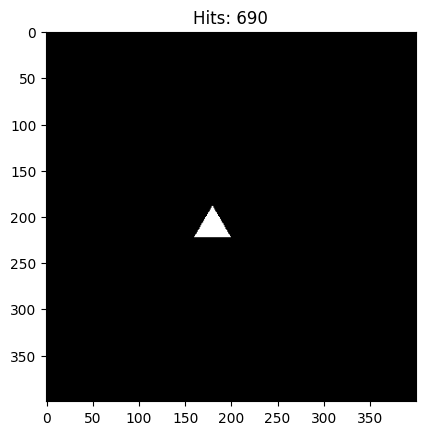

In [7]:
## Visualization test for a single triangle

import matplotlib.pyplot as plt

# Equilateral triangle in the XY plane
# Height ~ 1.732. Half-width = 1.0.
# V0: Bottom Left
# V1: Bottom Right
# V2: Top Center

single_v0 = jnp.array([[-1.0, -0.577, 0.0]])
single_v1 = jnp.array([[ 1.0, -0.577, 0.0]])
single_v2 = jnp.array([[ 0.0,  1.155, 0.0]])

IMAGE_WIDTH = 400
IMAGE_HEIGHT = 400

SAMPLES_PER_PIXEL = 2

# create_camera_rays_jax gives us normalized rays looking down -Z
# Our triangle is at Z=0. Camera creates rays starting at 0,0,0 by default.
# We need to move the camera back to Z=5 so it looks "forward" at the triangle at Z=0.
# OR, we just move the triangle to Z=-5 (where the camera is looking).
# Let's move the triangle to Z = -5 to match the camera default.

tri_z_offset = jnp.array([0.0, 0.0, -5.0])
v0s = single_v0 + tri_z_offset
v1s = single_v1 + tri_z_offset
v2s = single_v2 + tri_z_offset
origs, dirs = create_camera_rays_jax(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, samples_per_pixel=SAMPLES_PER_PIXEL)

v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(v0s, v1s, v2s)

# --- 3. Run Intersection ---
t, n, h = ray_triangle_intersect_closest(
    origs, 
    dirs, 
    v0s, v1s, v2s, tri_normals,
    M=1, 
    chunk_size=1
)

# --- 4. Flatten intersection mask ---
h = h.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH)
h = jnp.any(h, axis=0)

# --- 4. Visualize --
# h is shape (400,). Reshape to image.
hit_image = h.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
plt.imshow(hit_image, cmap='gray')
plt.title(f"Hits: {h.sum()}")
plt.show()

### Cornell Box

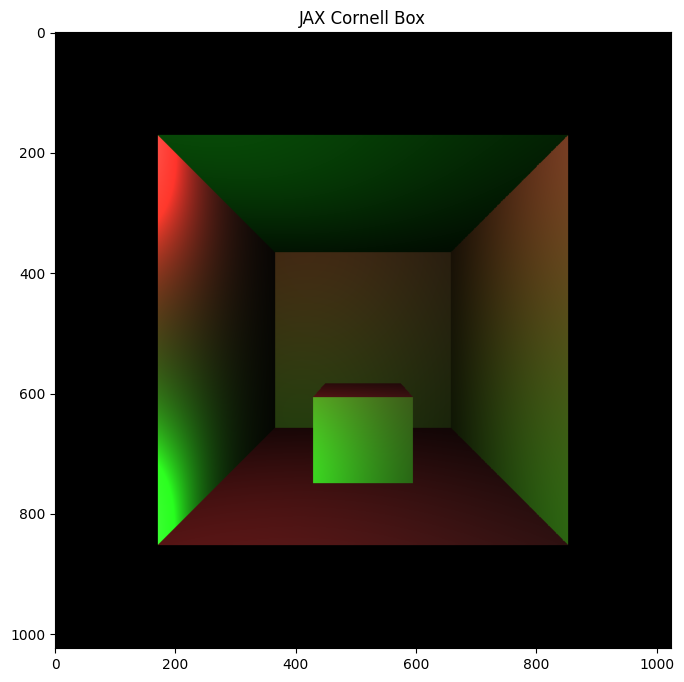

In [8]:
import matplotlib.pyplot as plt

def create_cornell_box_geometry():
    """
    Creates a simple cornell-style open box with a cube in the middle.
    Returns v0s, v1s, v2s arrays ready for intersection.
    """
    # Helpers to make quad from 4 points (CCW winding)
    def make_quad(p0, p1, p2, p3):
        # Tri 1: p0, p1, p2
        # Tri 2: p0, p2, p3
        return (
            jnp.array([p0, p0]), # v0s
            jnp.array([p1, p2]), # v1s
            jnp.array([p2, p3])  # v2s
        )
    # All lists to concatenate later
    all_v0, all_v1, all_v2 = [], [], []
    def add_quad(p0, p1, p2, p3):
        ts0, ts1, ts2 = make_quad(p0, p1, p2, p3)
        all_v0.append(ts0)
        all_v1.append(ts1)
        all_v2.append(ts2)
    # --- Room Dimensions ---
    # Centered at (0,0,-5), size 4x4x4
    # Left Wall x=-2, Right Wall x=2
    # Floor y=-2, Ceiling y=2
    # Back Wall z=-7 (Camera is at z=0 looking at -Z)
    
    L, R = -2.0, 2.0
    B, T = -2.0, 2.0 # Bot, Top
    F, Bk = -3.0, -7.0 # Front, Back (Z)
    # 1. Floor (y=B)
    add_quad([L, B, F], [R, B, F], [R, B, Bk], [L, B, Bk])
    # 2. Ceiling (y=T)
    add_quad([L, T, Bk], [R, T, Bk], [R, T, F], [L, T, F])
    # 3. Back Wall (z=Bk)
    add_quad([L, B, Bk], [R, B, Bk], [R, T, Bk], [L, T, Bk])
    # 4. Left Wall (x=L) (Green?)
    add_quad([L, B, F], [L, B, Bk], [L, T, Bk], [L, T, F])
    # 5. Right Wall (x=R) (Red?)
    add_quad([R, B, Bk], [R, B, F], [R, T, F], [R, T, Bk])
    # --- Center Cube ---
    # Size 1x1x1, centered at (0, -1.5, -5) -> sitting on floor
    cx, cy, cz = 0.0, -1.5, -5.0
    r = 0.7 # Radius
    
    # Cube Vertices
    c000 = [cx-r, cy-r, cz+r]
    c100 = [cx+r, cy-r, cz+r]
    c110 = [cx+r, cy+r, cz+r]
    c010 = [cx-r, cy+r, cz+r]
    c001 = [cx-r, cy-r, cz-r]
    c101 = [cx+r, cy-r, cz-r]
    c111 = [cx+r, cy+r, cz-r]
    c011 = [cx-r, cy+r, cz-r]
    # Front
    add_quad(c000, c100, c110, c010)
    # Back
    add_quad(c101, c001, c011, c111)
    # Left
    add_quad(c001, c000, c010, c011)
    # Right
    add_quad(c100, c101, c111, c110)
    # Top
    add_quad(c010, c110, c111, c011)
    # Bottom
    add_quad(c001, c101, c100, c000)
    # Concatenate all
    v0s = jnp.concatenate(all_v0, axis=0) # (M, 3)
    v1s = jnp.concatenate(all_v1, axis=0)
    v2s = jnp.concatenate(all_v2, axis=0)
    
    return v0s, v1s, v2s

v0s, v1s, v2s = create_cornell_box_geometry()
M_TRIS = v0s.shape[0]
CHUNK_SIZE = 20

DEFAULT_KEY = jax.random.PRNGKey(76)

# Setup Rays (use higher res for pretty pictue)
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024
SAMPLES_PER_PIXEL = 1

v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(v0s, v1s, v2s)

origs, dirs = create_camera_rays_jax(
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    samples_per_pixel=SAMPLES_PER_PIXEL,
    key=DEFAULT_KEY,
)

# Intersection
t, n, h = ray_triangle_intersect_closest(
    origs, dirs, v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, 
    chunk_size=CHUNK_SIZE,
)
hit_pos = origs + t[:, None] * dirs

# 1. Soft Red from the top
L1_POS = [ -1.5, 2.0, -2.0 ] # Moved back towards camera (z=-2)
L1_INT = [ 1.0, 0.1, 0.1 ]   # Reduced intensity
# 2. Soft Green from the bottom
L2_POS = [ -1.5, -2.0, -2.0 ]
L2_INT = [ 0.1, 1.0, 0.1 ]
# 3. Main White Light from High Front
L3_POS = [ 0.0, 3.0, 0.0 ]   # High up, at Camera Z
L3_INT = [ 0.5, 0.5, 0.5 ]   # Neutral fill
LIGHT_POS = jnp.array([L1_POS, L2_POS, L3_POS])
LIGHT_INT = jnp.array([L1_INT, L2_INT, L3_INT]) * 5.

# ... Calculate Lighting ...
diffuse = calculate_diffuse_lighting_jax(LIGHT_POS, LIGHT_INT, hit_pos, n)

# Use the average of the samples per pixel
diffuse = diffuse.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH, 3)
diffuse = jnp.mean(diffuse, axis=0)

# Flatten hit intersections
h = h.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH)
h = jnp.any(h, axis=0)

# # Compose Image
final_color = jnp.where(h[:, None], diffuse, jnp.array([0.0, 0.0, 0.0]))
final_image = jnp.clip(final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 0, 1)
plt.figure(figsize=(8,8))
plt.imshow(final_image)
plt.title("JAX Cornell Box")
plt.show()

### Cornell Box with Hard Shadows

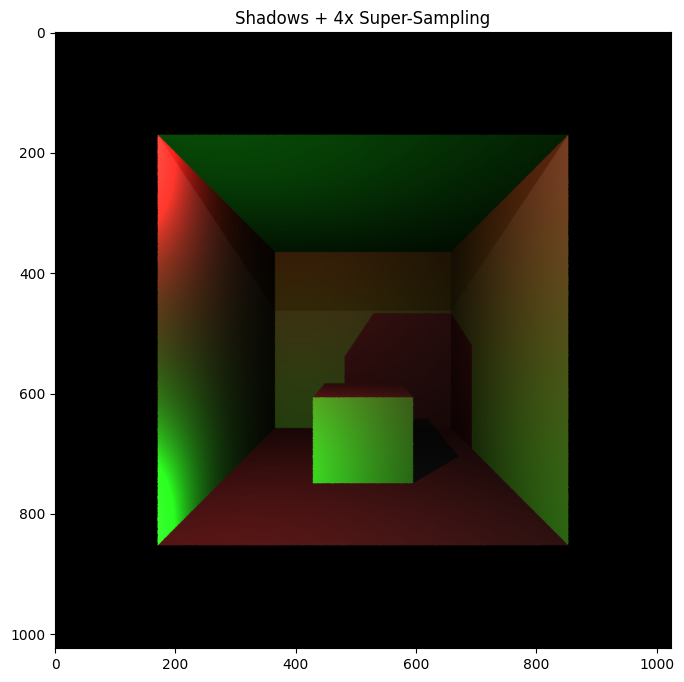

In [9]:
# -- Configuration --
SAMPLES = 4 # Super-sampling factor
KEY = jax.random.PRNGKey(42)

# -- Generate Rays (Super-Sampled) --
# origs: (N_Pixels, 3) --> Static
# dirs: (Samples, N_Pixels, 3) --> Jittered
o, d = create_camera_rays_jax(
    width=IMAGE_WIDTH, height=IMAGE_HEIGHT, 
    samples_per_pixel=SAMPLES, key=KEY
)

# -- Intersection Test --
t, n, h = ray_triangle_intersect_closest(
    o, d, v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, chunk_size=min(M_TRIS, 128)
)

# -- Hit position - i.e. world coordinates of ray and triangle intersection --
hit_pos = o + t[:, None] * d

# -- Calculate Diffuse Lighting + Shadows --
# Note: unit_normals = normals calculated at the hit position.
# mesh_normals = geometric normals of the triangle
# mesh_normals == unit_normals in our flat shading implementation, but will be different if using smooth shading within a triangle

diffuse_flat = calculate_lighting_with_shadows_jax(
    light_positions=LIGHT_POS,
    light_intensities=LIGHT_INT,
    hit_positions=hit_pos,
    unit_normals=n, v0s=v0s, v0v1s=v0v1s, v0v2s=v0v2s, mesh_normals=tri_normals,
    M=M_TRIS, chunk_size=min(M_TRIS, 128)
)

# 7. Background & Reshape
# If no hit, use black (or background color)
final_flat = jnp.where(h[:, None], diffuse_flat, jnp.array([0.0, 0.0, 0.0]))

# Reshape to (Samples, Height, Width, 3)
final_samples = final_flat.reshape(SAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# 8. Super-Sampling Resolve (Average)
# Average across the Samples axis (axis 0)
final_image = jnp.mean(final_samples, axis=0)

# Clip & Display
final_image = jnp.clip(final_image, 0.0, 1.0)
plt.figure(figsize=(8,8))
plt.imshow(final_image)
plt.title(f"Shadows + {SAMPLES}x Super-Sampling")
plt.show()


### Stanford Bunny

Loaded models/bunny.obj: 4968 triangles.
Center: [-0.5040244  3.3045888 -6.044468 ]
Intersection time: 3.82 seconds
Lighting time: 3.43 seconds


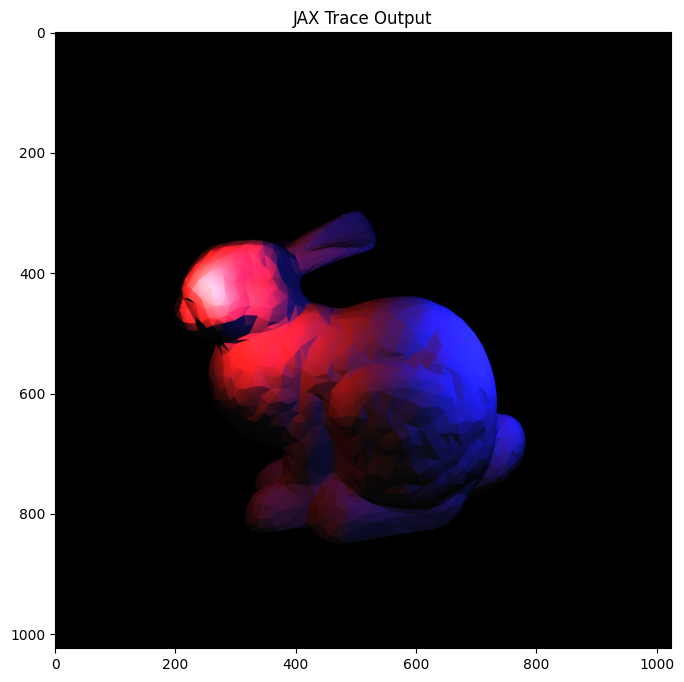

In [3]:
from obj_loader import load_obj
import matplotlib.pyplot as plt

import time

# Load geometry
# v0s, v1s, v2s, centre = load_obj('models/xyzrgb_dragon.obj', scale=0.2, translation=[0, 0, -15])
# v0s, v1s, v2s, centre = load_obj('models/teapot.obj', scale=1.0, translation=[0, -2.3, -5.7])
v0s, v1s, v2s, centre = load_obj('models/bunny.obj', scale=30.0, translation=[0, 0, -6])

M_TRIS = v0s.shape[0]
CHUNK_SIZE = 20

DEFAULT_KEY = jax.random.PRNGKey(76)

BACKGROUND_COLOR = jnp.array([0.0, 0.0, 0.0])

# Setup Rays (use higher res for pretty pictue)
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024
SAMPLES_PER_PIXEL = 8

v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(v0s, v1s, v2s)

origs, dirs = create_camera_rays_jax(
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    samples_per_pixel=SAMPLES_PER_PIXEL,
    key=DEFAULT_KEY,
    # camera_pos=centre + jnp.array([0, 0, -25]),
    camera_pos=centre + jnp.array([0, 0, 5]),
    look_at=centre,
)

intersect_start_time = time.time()

# Intersection
t, n, h = ray_triangle_intersect_closest(
    origs, dirs, v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, 
    chunk_size=CHUNK_SIZE,
)
hit_pos = origs + t[:, None] * dirs

intersect_end_time = time.time() - intersect_start_time
print(f"Intersection time: {intersect_end_time:.2f} seconds")

# Bunny lighting
# 1. Red from the top-left
L1_POS = jnp.array([ -0.5, 1.0, -1.0 ]) * 4
L1_INT = jnp.array([ 1., 0.1, 0.1 ]) * 2
# 2. Blue from the top-right
L2_POS = jnp.array([ 0.5, 1.0, -1.0 ]) * 4
L2_INT = jnp.array([ 0.1, 0.1, 1. ]) * 5.
# 3. White Light from High Front
L3_POS = jnp.array([ 0.0, 1.0, 1.0 ]) * 4
L3_INT = jnp.array([ 1.0, 1.0, 1.0 ]) * 3
LIGHT_POS = jnp.array([L1_POS, L2_POS, L3_POS])
LIGHT_INT = jnp.array([L1_INT, L2_INT, L3_INT])

light_start_time = time.time()

# ... Calculate Lighting ...
diffuse = calculate_diffuse_lighting_jax(LIGHT_POS, LIGHT_INT, hit_pos, n)

light_end_time = time.time() - light_start_time
print(f"Lighting time: {light_end_time:.2f} seconds")

# Use the average of the samples per pixel

diffuse_with_bg = jnp.where(h[:, None], diffuse, BACKGROUND_COLOR)
diffuse_with_bg = diffuse_with_bg.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH, 3)
final_color = jnp.mean(diffuse_with_bg, axis=0)
final_color = jnp.clip(final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 0, 1)
final_color = final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3)

plt.figure(figsize=(8,8))
plt.imshow(final_color)
plt.title("JAX Trace Output")
plt.show()

### Stanford Dragon (Single Device)

Loaded models/xyzrgb_dragon.obj: 249882 triangles.
Center: [  0.44830036  -1.3464317  -13.0281    ]
Intersection time: 158.63 seconds
Lighting time: 3.43 seconds


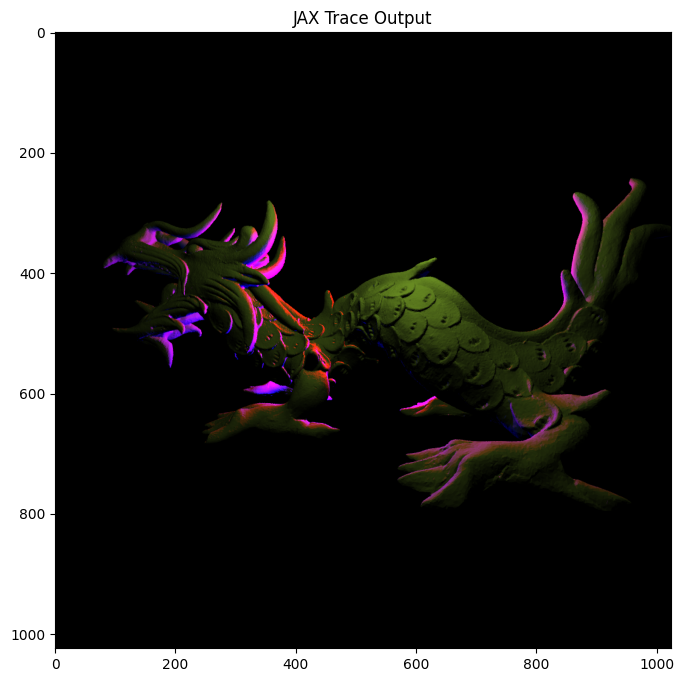

In [ ]:
from obj_loader import load_obj
import matplotlib.pyplot as plt

import time

# Load geometry
v0s, v1s, v2s, centre = load_obj('models/xyzrgb_dragon.obj', scale=0.2, translation=[0, 0, -15])
# v0s, v1s, v2s, centre = load_obj('models/teapot.obj', scale=1.0, translation=[0, -2.3, -5.7])
# v0s, v1s, v2s, centre = load_obj('models/bunny_high.obj', scale=30.0, translation=[0, 0, -6])

M_TRIS = v0s.shape[0]
CHUNK_SIZE = 20

DEFAULT_KEY = jax.random.PRNGKey(76)

BACKGROUND_COLOR = jnp.array([0.0, 0.0, 0.0])

# Setup Rays (use higher res for pretty pictue)
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024
SAMPLES_PER_PIXEL = 8

v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(v0s, v1s, v2s)

origs, dirs = create_camera_rays_jax(
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    samples_per_pixel=SAMPLES_PER_PIXEL,
    key=DEFAULT_KEY,
    camera_pos=centre + jnp.array([0, 0, -25]),
    look_at=centre,
)

single_device_start_time = time.time()

# Intersection
t, n, h = ray_triangle_intersect_closest(
    origs, dirs, v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, 
    chunk_size=CHUNK_SIZE,
)
hit_pos = origs + t[:, None] * dirs

single_device_end_time = time.time() - single_device_start_time
print(f"Intersection time: {single_device_end_time:.2f} seconds")

# Dragon lighting
# 1. Red from the top-left
L1_POS = jnp.array([ -1, 3.0, -6.0 ]) * 1
L1_INT = jnp.array([ 1., 0, 0 ]) * 300
# 2. Blue from the top-right
L2_POS = jnp.array([ 1, -3.0, -6.0 ]) * 1
L2_INT = jnp.array([ 0., 0, 1 ]) * 350
# 3. Green Light from High Front
L3_POS = jnp.array([ 5.0, 3.0, -6.0 ]) * 4
L3_INT = jnp.array([ 0.3, 0.4, 0.1 ]) * 300
# 4. White Light near the centre
L4_POS = jnp.array([ 0.0, 3.0, -6.0 ]) * 4
L4_INT = jnp.array([ 1.0, 0.0, 1.0 ]) * 100

light_start_time = time.time()

# ... Calculate Lighting ...
diffuse = calculate_diffuse_lighting_jax(LIGHT_POS, LIGHT_INT, hit_pos, n)

light_end_time = time.time() - light_start_time
print(f"Lighting time: {light_end_time:.2f} seconds")

# Use the average of the samples per pixel

diffuse_with_bg = jnp.where(h[:, None], diffuse, BACKGROUND_COLOR)
diffuse_with_bg = diffuse_with_bg.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH, 3)
final_color = jnp.mean(diffuse_with_bg, axis=0)
final_color = jnp.clip(final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 0, 1)
final_color = final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3)

plt.figure(figsize=(8,8))
plt.imshow(final_color)
plt.title("JAX Trace Output")
plt.show()

In [5]:
import numpy as np
from PIL import Image

# Convert JAX array to numpy and ensure it's in [0, 1] range
final_color_np = np.array(final_color)
final_color_np = np.clip(final_color_np, 0.0, 1.0)

# Convert to 8-bit RGB (0-255)
final_color_8bit = (final_color_np * 255).astype(np.uint8)

# Save to PNG
img = Image.fromarray(final_color_8bit, mode='RGB')
img.save('render_output.png')
print("Saved render_output.png")

Saved render_output.png


### Stanford Dragon (Multi-Device using JAX SPMD)

The strategy is to shard rays evenly across accelerators, and replicate the triangle mesh.

Rays are shaped as (num_rays, 3), split on axis 0. Triangles are currently stored as arrays for each vertex of shape (num_triangles, 3), split on axis 1.

In [ ]:
from obj_loader import load_obj
import matplotlib.pyplot as plt
from jax.sharding import PartitionSpec as P

# We have two GPUs
mesh = jax.make_mesh((1, 2), ('x', 'y'))
tri_mesh_sharding = jax.sharding.NamedSharding(mesh, P())

# Load geometry - the vertices are of shape (num_pixels, 3), shard the first dimension (num_pixels) across the y-axis. If num_pixels is not evenly divisible, then we need to pad that dimension.
v0s, v1s, v2s, centre = load_obj('models/xyzrgb_dragon.obj', scale=0.2, translation=[0, 0, -15])
# v0s, v1s, v2s, centre = load_obj('models/teapot.obj', scale=1.0, translation=[0, -2.3, -5.7])
# v0s, v1s, v2s, centre = load_obj('models/bunny.obj', scale=35.0, translation=[0, 0, -6])

v0s = jax.device_put(v0s, tri_mesh_sharding)
v1s = jax.device_put(v1s, tri_mesh_sharding)
v2s = jax.device_put(v2s, tri_mesh_sharding)

jax.debug.visualize_array_sharding(v0s)


/tmp/ipykernel_7752/2043602685.py:6: DeprecationWarning: The default axis_types will change in JAX v0.9.0 to jax.sharding.AxisType.Explicit. To maintain the old behavior, pass `axis_types=(jax.sharding.AxisType.Auto,) * len(axis_names)`. To opt-into the new behavior, pass `axis_types=(jax.sharding.AxisType.Explicit,) * len(axis_names)
  mesh = jax.make_mesh((1, 2), ('x', 'y'))


Loaded models/xyzrgb_dragon.obj: 249882 triangles.
Center: [  0.44830036  -1.3464317  -13.0281    ]


         
         
         
         
         
 GPU 0,1 
         
         
         
         
         

In [4]:
v0v1s, v0v2s, tri_normals = precompute_triangle_geometry(v0s, v1s, v2s)

# Also shard the precomputed geometry across devices
v0v1s = jax.device_put(v0v1s, tri_mesh_sharding)
v0v2s = jax.device_put(v0v2s, tri_mesh_sharding)
tri_normals = jax.device_put(tri_normals, tri_mesh_sharding)

jax.debug.visualize_array_sharding(v0v1s)


         
         
         
         
         
 GPU 0,1 
         
         
         
         
         

In [38]:
# Setup Rays (use higher res for pretty pictue)
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024
SAMPLES_PER_PIXEL = 8

DEFAULT_KEY = jax.random.PRNGKey(76)

origs, dirs = create_camera_rays_jax(
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    samples_per_pixel=SAMPLES_PER_PIXEL,
    key=DEFAULT_KEY,
    camera_pos=centre + jnp.array([28, 2, -8]),
    # camera_pos=centre + jnp.array([0, 0, 5]),
    look_at=centre,
)

ray_sharding = jax.sharding.NamedSharding(mesh, P('y', None))
origs = jax.device_put(origs, ray_sharding)
dirs = jax.device_put(dirs, ray_sharding)

jax.debug.visualize_array_sharding(origs)

         
         
  GPU 0  
         
         
         
         
         
  GPU 1  
         
         
         

In [39]:
M_TRIS = v0s.shape[0]
CHUNK_SIZE = 20

spmd_start_time = time.time()

# Intersection
t, n, h = ray_triangle_intersect_closest(
    origs, dirs, v0s, v0v1s, v0v2s, tri_normals,
    M=M_TRIS, 
    chunk_size=CHUNK_SIZE,
)

spmd_end_time = time.time() - spmd_start_time
print(f"SPMD Intersection Time: {spmd_end_time:.4f} seconds")

hit_pos = origs + t[:, None] * dirs
jax.debug.visualize_array_sharding(hit_pos)

SPMD Intersection Time: 75.9267 seconds


         
         
  GPU 0  
         
         
         
         
         
  GPU 1  
         
         
         

Lighting time: 0.02 seconds


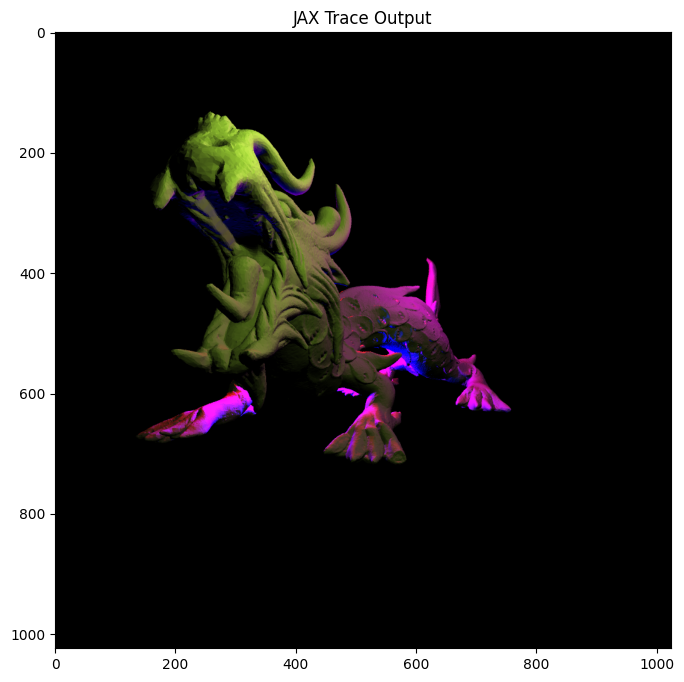

In [40]:
BACKGROUND_COLOR = jnp.array([0.0, 0.0, 0.0])

# Dragon lighting
# 1. Red from the top-left
L1_POS = jnp.array([ -1, 3.0, -6.0 ]) * 1
L1_INT = jnp.array([ 1., 0, 0 ]) * 300
# 2. Blue from the top-right
L2_POS = jnp.array([ 1, -3.0, -6.0 ]) * 1
L2_INT = jnp.array([ 0., 0, 1 ]) * 350
# 3. Green Light from High Front
L3_POS = jnp.array([ 5.0, 3.0, -6.0 ]) * 4
L3_INT = jnp.array([ 0.3, 0.4, 0.1 ]) * 300
# 4. White Light near the centre
L4_POS = jnp.array([ 0.0, 3.0, -6.0 ]) * 4
L4_INT = jnp.array([ 1.0, 0.0, 1.0 ]) * 100

LIGHT_POS = jnp.array([L1_POS, L2_POS, L3_POS, L4_POS])
LIGHT_INT = jnp.array([L1_INT, L2_INT, L3_INT, L4_INT])

light_start_time = time.time()

# ... Calculate Lighting ...
diffuse = calculate_diffuse_lighting_jax(LIGHT_POS, LIGHT_INT, hit_pos, n)

light_end_time = time.time() - light_start_time
print(f"Lighting time: {light_end_time:.2f} seconds")

# Use the average of the samples per pixel

diffuse_with_bg = jnp.where(h[:, None], diffuse, BACKGROUND_COLOR)
diffuse_with_bg = diffuse_with_bg.reshape(SAMPLES_PER_PIXEL, IMAGE_HEIGHT * IMAGE_WIDTH, 3)
final_color = jnp.mean(diffuse_with_bg, axis=0)
final_color = jnp.clip(final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 0, 1)
final_color = final_color.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3)

plt.figure(figsize=(8,8))
plt.imshow(final_color)
plt.title("JAX Trace Output")
plt.show()